In [13]:

path = 'jigsaw-toxic-comment-classification-challenge/train.csv'
import pandas as pd

df = pd.read_csv(path)


df.head(10)


#!pip list


from tensorflow.keras.layers import TextVectorization

X = df['comment_text'].astype(str)
y = df[df.columns[2:]].values

MAX_FEATURES = 10000
SEQUENCE_LENGTH = 1000
vectorizer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
aiohappyeyeballs             2.4.4
aiohttp                      3.11.10
aiosignal                    1.2.0
anyio                        4.9.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    3.0.0
astunparse                   1.6.3
async-lru                    2.0.5
async-timeout                5.0.1
attrs                        24.3.0
babel                        2.17.0
beautifulsoup4               4.13.4
bleach                       6.2.0
blinker                      1.9.0
Bottleneck                   1.4.2
Brotli                       1.0.9
cachetools                   5.5.1
certifi                      2025.4.26
cffi                         1.17.1
charset-normalizer           3.3.2
click                        8.1.8
colorama                     0.4.6
comm                         0.2

In [14]:
import os
import tensorflow as tf


# os.environ['CUDA_HOME'] = '/usr/local/cuda'
# os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64'

# Вывести список доступных GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Available GPUs:", gpus)

if gpus:
    try:

        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs configured.")
    except RuntimeError as e:

        print("Error setting up GPU memory growth:", e)
else:
    print("GPU devices not found, running on CPU.")


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Error setting up GPU memory growth: Physical devices cannot be modified after being initialized


In [15]:

import tensorflow as tf
from tensorflow.keras import mixed_precision


mixed_precision.set_global_policy('mixed_float16')


path = 'jigsaw-toxic-comment-classification-challenge/train.csv'
import pandas as pd

df = pd.read_csv(path)


from tensorflow.keras.layers import TextVectorization

X = df['comment_text'].astype(str)
y = df[df.columns[2:]].values


MAX_FEATURES = 5000  # (before 10000)
SEQUENCE_LENGTH = 500  # (before 1000)
vectorizer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)
vectorizer.adapt(X.values)

In [16]:

BATCH_SIZE = 32  # увеличение батча ускоряет обучение на GPU

dataset = tf.data.Dataset.from_tensor_slices((X.values, y))
dataset = dataset.shuffle(buffer_size=60000)
dataset = dataset.map(
    lambda text, label: (vectorizer(text), label),
    num_parallel_calls=tf.data.AUTOTUNE
)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

# Разбиение на train/val/test
data_size = tf.data.experimental.cardinality(dataset).numpy()
train_size = int(0.7 * data_size)
val_size = int(0.2 * data_size)

train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size + val_size)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model = Sequential([
    Embedding(input_dim=MAX_FEATURES + 1, output_dim=32, input_length=SEQUENCE_LENGTH),

    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=2e-4),
    metrics=['accuracy']
)
model.summary()


early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)
checkpoint = ModelCheckpoint('best_toxic_lstm_jigsaw_fast.h5', monitor='val_loss', save_best_only=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           160032    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                      

In [18]:
# 5. Обучение модели
EPOCHS = 10
history = model.fit(
    train,
    epochs=EPOCHS,
    validation_data=val,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/10
3490/3490 [==============================] - 348s 98ms/step - loss: 0.1028 - accuracy: 0.8129 - val_loss: 0.0597 - val_accuracy: 0.9938 - lr: 2.0000e-04
Epoch 2/10
3490/3490 [==============================] - 528s 151ms/step - loss: 0.0581 - accuracy: 0.9740 - val_loss: 0.0518 - val_accuracy: 0.9943 - lr: 2.0000e-04
Epoch 3/10
3490/3490 [==============================] - 295s 84ms/step - loss: 0.0529 - accuracy: 0.9884 - val_loss: 0.0505 - val_accuracy: 0.9944 - lr: 2.0000e-04
Epoch 4/10
3490/3490 [==============================] - 326s 94ms/step - loss: 0.0515 - accuracy: 0.9897 - val_loss: 0.0482 - val_accuracy: 0.9938 - lr: 2.0000e-04
Epoch 5/10
3490/3490 [==============================] - 340s 97ms/step - loss: 0.0505 - accuracy: 0.9897 - val_loss: 0.0474 - val_accuracy: 0.9940 - lr: 2.0000e-04
Epoch 6/10
3490/3490 [==============================] - 320s 92ms/step - loss: 0.0498 - accuracy: 0.9892 - val_loss: 0.0460 - val_accuracy: 0.9941 - lr: 2.0000e-04
Epoch 7/10
3490

In [19]:
# 7. Оценка на тестовом наборе
model.load_weights('best_toxic_lstm_jigsaw_fast.h5')
test_loss, test_acc = model.evaluate(test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

500/500 [==============================] - 28s 43ms/step - loss: 0.0468 - accuracy: 0.9940
Test Loss: 0.0468, Test Accuracy: 0.9940


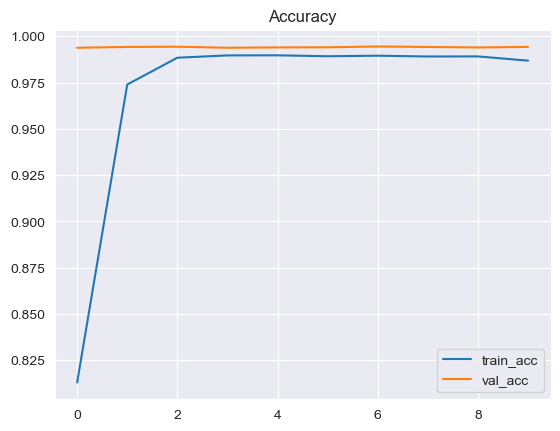

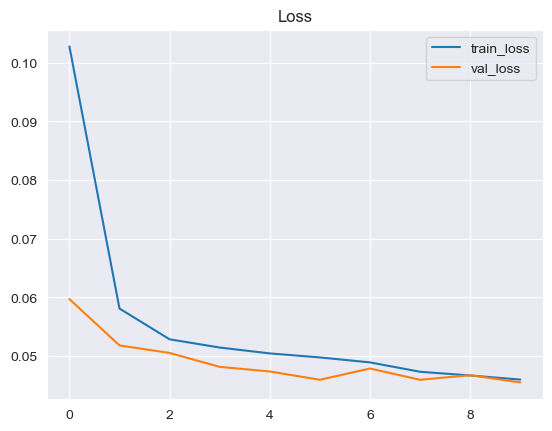

In [20]:
# 8. Визуализация метрик
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend(); plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend(); plt.show()